# Non-Linear Regression Models

Beyond linear relationships: polynomials, step functions, splines, and generalized additive models.

## Contents
1. Polynomial Regression
2. Step Functions
3. Regression Splines
4. Smoothing Splines
5. Local Regression (LOESS)
6. Generalized Additive Models (GAMs)

## Setup and Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy import interpolate
from scipy.interpolate import BSpline, splrep, splev
import warnings
warnings.filterwarnings('ignore')

# Try to import pygam, if not available we'll use alternatives
try:
    from pygam import LinearGAM, s, f
    PYGAM_AVAILABLE = True
except ImportError:
    PYGAM_AVAILABLE = False
    print("Note: pygam not installed. GAM section will use alternatives.")
    print("Install with: pip install pygam")

plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Load Wage Dataset

In [3]:
# Load Wage dataset
url = "https://raw.githubusercontent.com/selva86/datasets/master/Wage.csv"
Wage = pd.read_csv(url)

print(f"Dataset shape: {Wage.shape}")
print(f"\nColumn names:")
print(Wage.columns.tolist())
print(f"\nFirst few rows:")
Wage.head()

Dataset shape: (3000, 12)

Column names:
['year', 'age', 'sex', 'maritl', 'race', 'education', 'region', 'jobclass', 'health', 'health_ins', 'logwage', 'wage']

First few rows:


,year,age,sex,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Male,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Male,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,1. Male,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,2003,43,1. Male,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,2005,50,1. Male,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


In [4]:
# Dataset summary
print("Summary statistics:")
Wage[['age', 'year', 'wage']].describe()

Summary statistics:


,age,year,wage
count,3000.000000,3000.000000,3000.000000
mean,42.414667,2005.791000,111.703608
std,11.542406,2.026167,41.728595
min,18.000000,2003.000000,20.085537
25%,33.750000,2004.000000,85.383940
50%,42.000000,2006.000000,104.921507
75%,51.000000,2008.000000,128.680488
max,80.000000,2009.000000,318.342430


## 1. Polynomial Regression

Fit a polynomial function of age to predict wage.

In [5]:
# Prepare data
X = Wage[['age']]
y = Wage['wage']

# Create age grid for predictions
age_min, age_max = Wage['age'].min(), Wage['age'].max()
age_grid = np.linspace(age_min, age_max, 100).reshape(-1, 1)

print(f"Age range: {age_min} to {age_max}")

Age range: 18 to 80


In [6]:
# Fit polynomial of degree 4
poly = PolynomialFeatures(degree=4, include_bias=False)
X_poly = poly.fit_transform(X)
X_grid_poly = poly.transform(age_grid)

model_poly4 = LinearRegression()
model_poly4.fit(X_poly, y)

# Get predictions with confidence intervals
y_pred = model_poly4.predict(X_grid_poly)

# Calculate standard errors (approximate)
residuals = y - model_poly4.predict(X_poly)
mse = np.mean(residuals**2)
se = np.sqrt(mse)

print(f"Polynomial Regression (degree 4):")
print(f"Coefficients: {model_poly4.coef_}")
print(f"Intercept: {model_poly4.intercept_:.2f}")
print(f"MSE: {mse:.2f}")
print(f"R²: {r2_score(y, model_poly4.predict(X_poly)):.4f}")

Polynomial Regression (degree 4):
Coefficients: [ 2.12455205e+01 -5.63859313e-01  6.81068771e-03 -3.20383037e-05]
Intercept: -184.15
MSE: 1590.53
R²: 0.0863


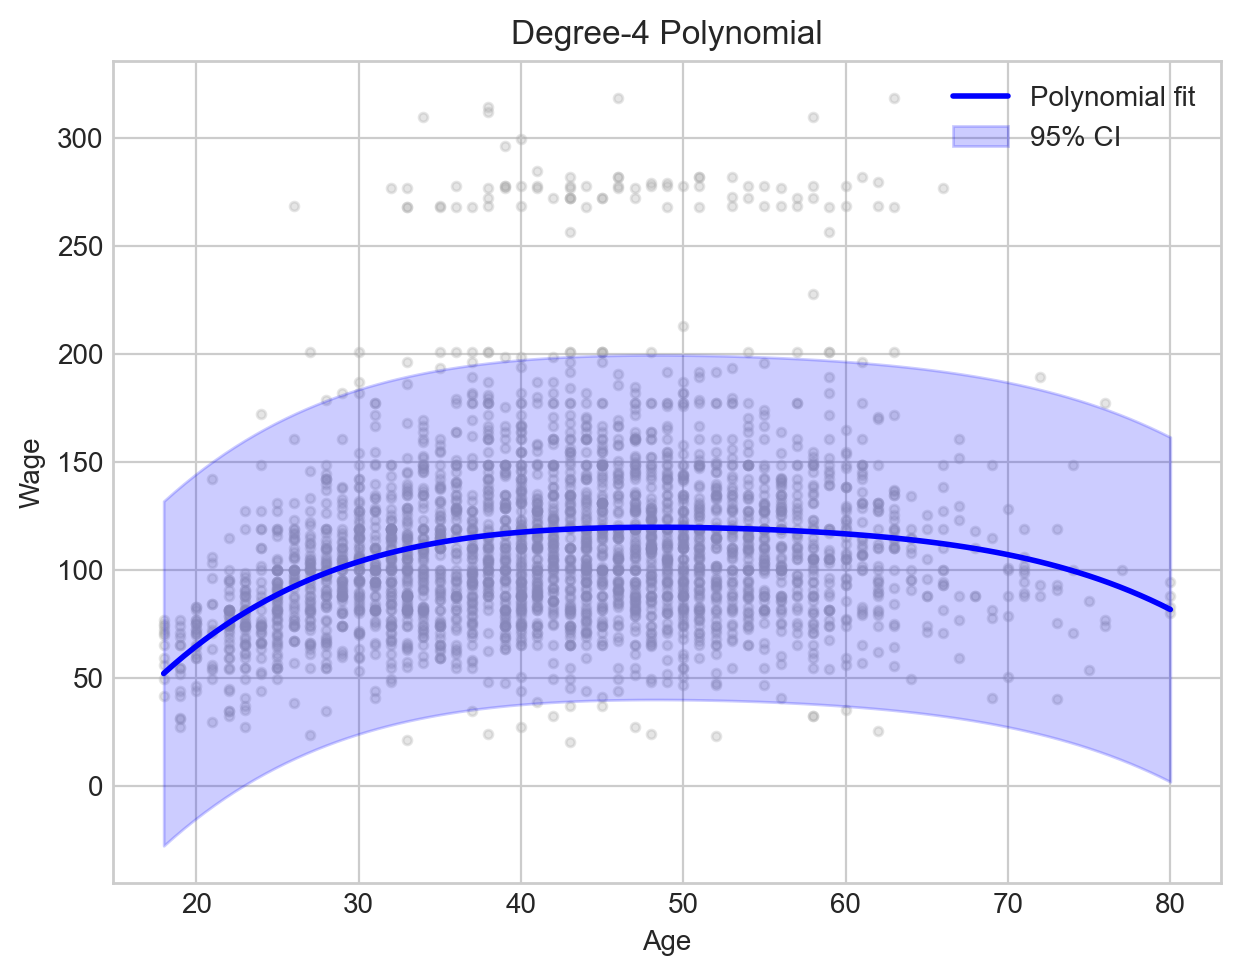

In [7]:
# Plot polynomial fit
plt.figure(figsize=(12, 5))

# Left plot: Degree-4 Polynomial
plt.subplot(1, 2, 1)
plt.scatter(Wage['age'], Wage['wage'], alpha=0.3, s=10, color='darkgray')
plt.plot(age_grid, y_pred, 'b-', linewidth=2, label='Polynomial fit')

# Confidence bands (approximate)
plt.fill_between(age_grid.ravel(), 
                 y_pred - 2*se, 
                 y_pred + 2*se, 
                 alpha=0.2, color='blue', label='95% CI')

plt.xlabel('Age')
plt.ylabel('Wage')
plt.title('Degree-4 Polynomial')
plt.legend()
plt.tight_layout()
plt.show()

### Model Selection: Which Polynomial Degree?

In [8]:
# Fit polynomials of degree 1-5
models = {}
r2_scores = []
mse_scores = []

for degree in range(1, 6):
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_poly = poly.fit_transform(X)
    
    model = LinearRegression()
    model.fit(X_poly, y)
    
    y_pred = model.predict(X_poly)
    r2 = r2_score(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    
    models[degree] = model
    r2_scores.append(r2)
    mse_scores.append(mse)
    
    print(f"Degree {degree}: R² = {r2:.4f}, MSE = {mse:.2f}")

# Display summary
results_df = pd.DataFrame({
    'Degree': range(1, 6),
    'R²': r2_scores,
    'MSE': mse_scores
})

print("\n" + "="*50)
print("POLYNOMIAL DEGREE COMPARISON")
print("="*50)
print(results_df.to_string(index=False))
print("="*50)

Degree 1: R² = 0.0383, MSE = 1674.07
Degree 2: R² = 0.0821, MSE = 1597.81
Degree 3: R² = 0.0851, MSE = 1592.56
Degree 4: R² = 0.0863, MSE = 1590.53
Degree 5: R² = 0.0865, MSE = 1590.11

POLYNOMIAL DEGREE COMPARISON
 Degree       R²         MSE
      1 0.038274 1674.072035
      2 0.082085 1597.810032
      3 0.085102 1592.558134
      4 0.086265 1590.534750
      5 0.086510 1590.107229


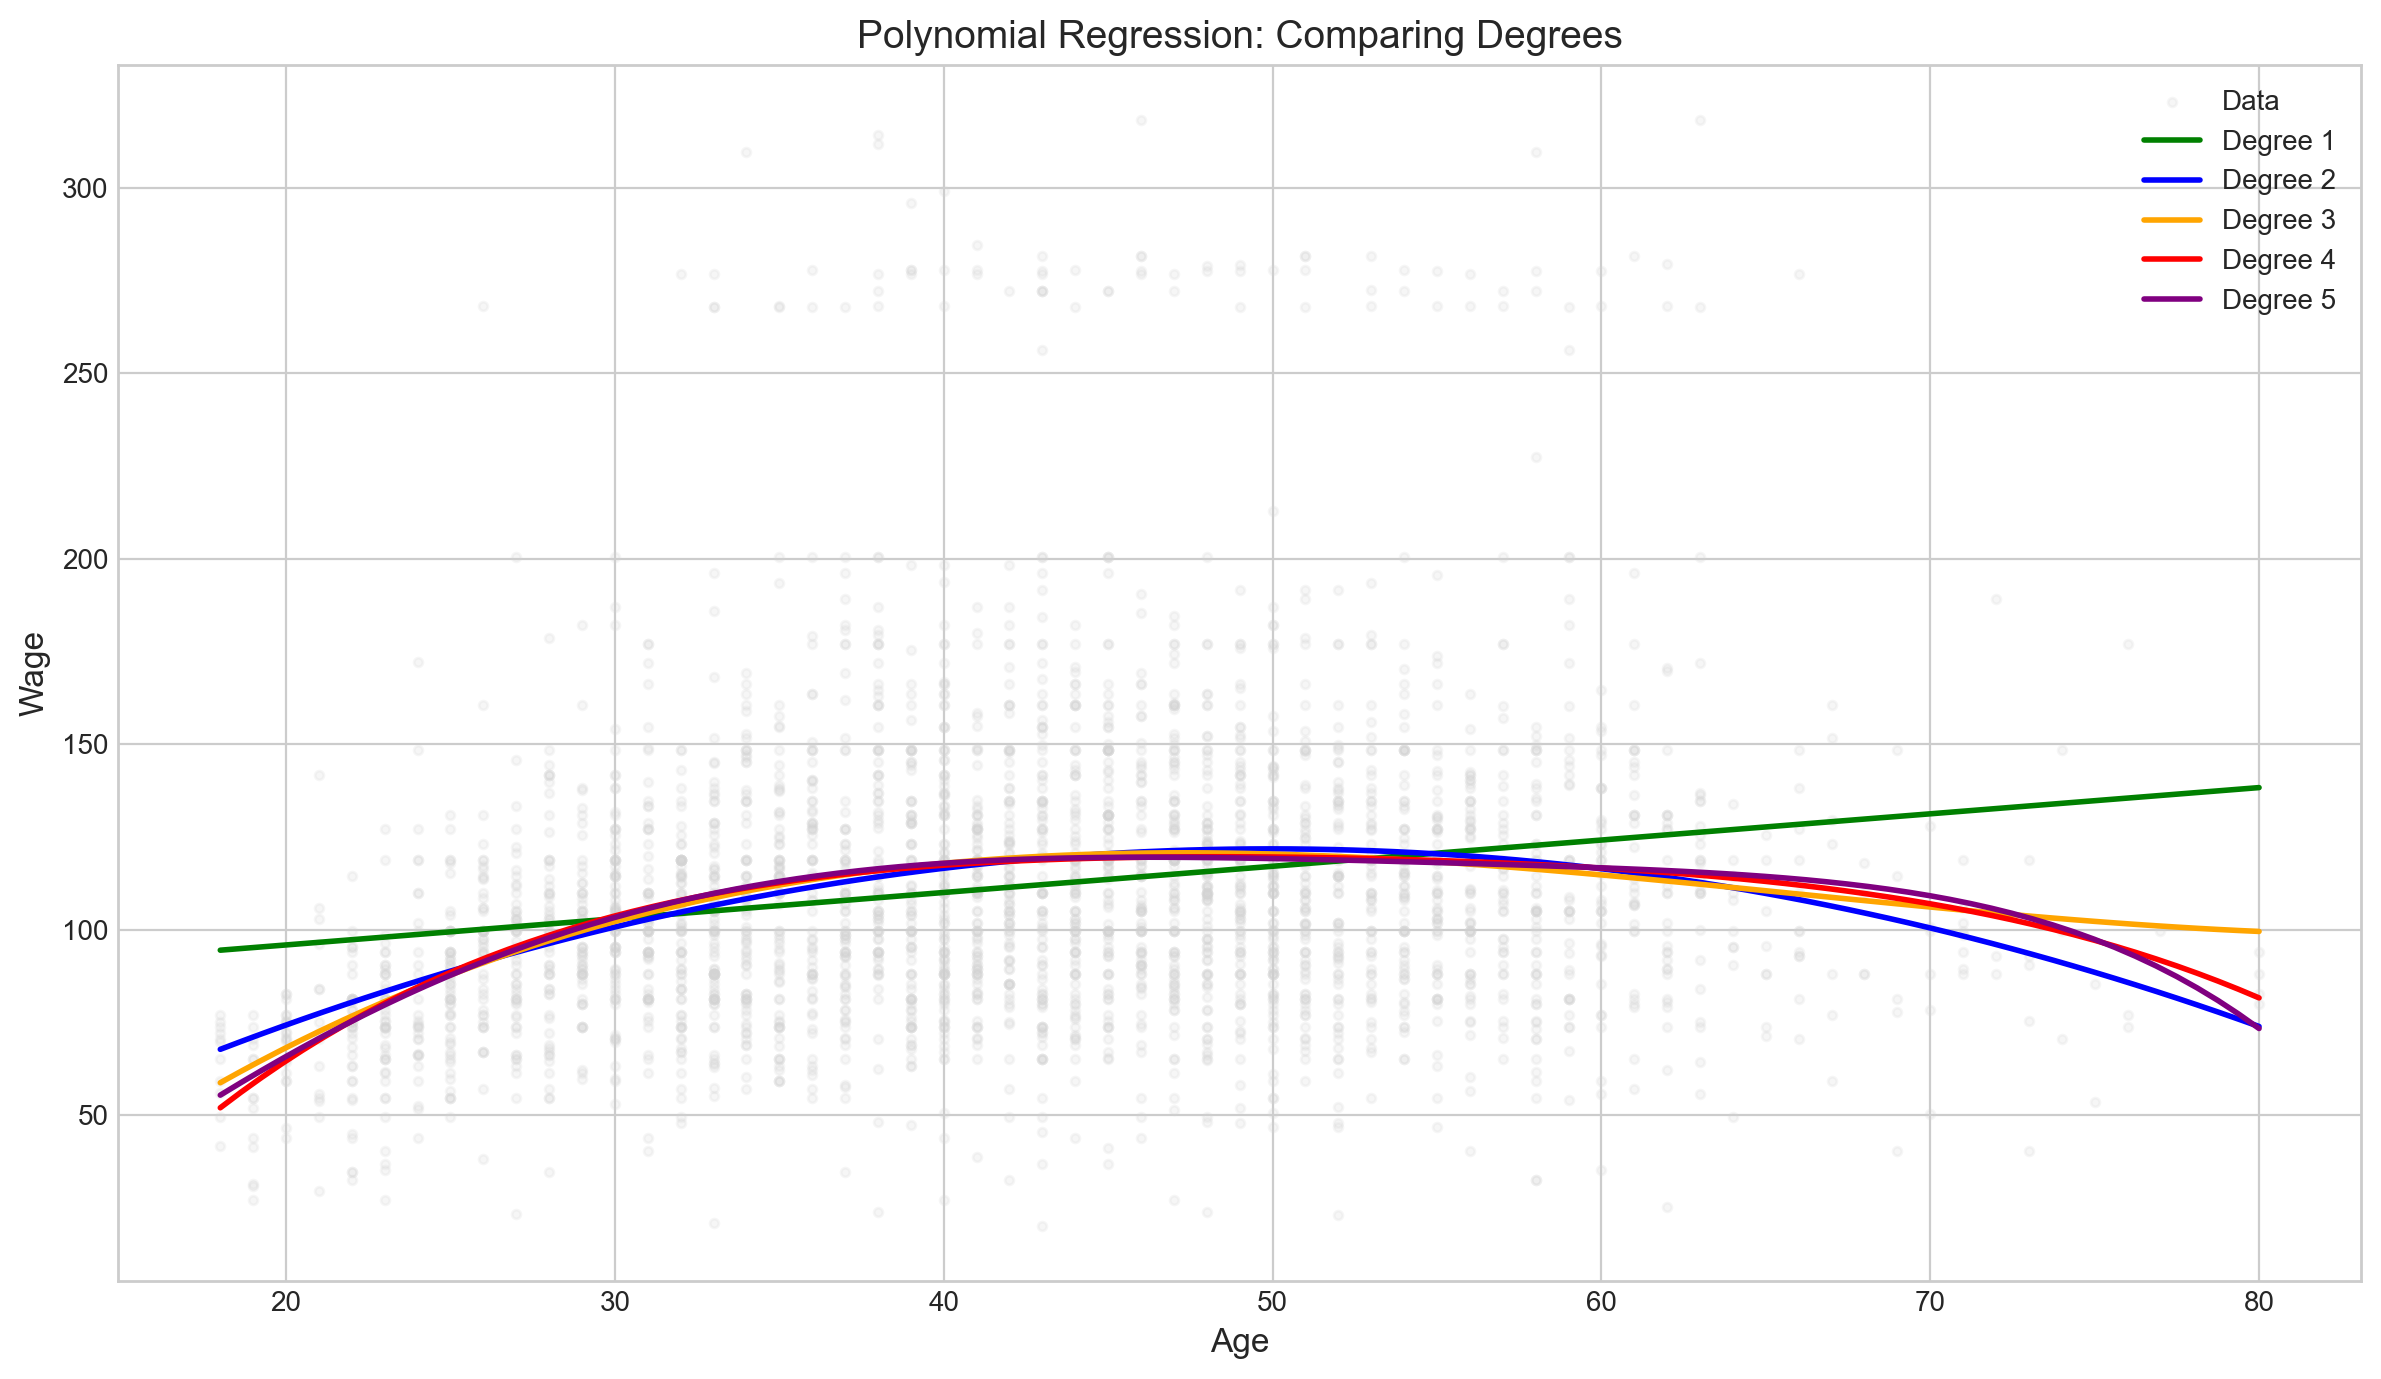

Observation: Higher degrees fit the data better but may overfit
Degree 4 seems like a good balance


In [9]:
# Visualize all polynomial fits
plt.figure(figsize=(12, 7))

plt.scatter(Wage['age'], Wage['wage'], alpha=0.2, s=10, color='lightgray', label='Data')

colors = ['green', 'blue', 'orange', 'red', 'purple']
for degree, color in zip(range(1, 6), colors):
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_grid_poly = poly.fit_transform(age_grid)
    y_pred = models[degree].predict(X_grid_poly)
    plt.plot(age_grid, y_pred, color=color, linewidth=2, label=f'Degree {degree}')

plt.xlabel('Age', fontsize=12)
plt.ylabel('Wage', fontsize=12)
plt.title('Polynomial Regression: Comparing Degrees', fontsize=14)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

print("Observation: Higher degrees fit the data better but may overfit")
print("Degree 4 seems like a good balance")

### Logistic Regression: Predict High Earners (>$250k)

In [10]:
# Create binary target: wage > 250
y_binary = (Wage['wage'] > 250).astype(int)

print(f"High earners (>$250k): {y_binary.sum()} out of {len(y_binary)} ({y_binary.mean()*100:.1f}%)")

# Fit logistic regression with polynomial features
poly = PolynomialFeatures(degree=4, include_bias=False)
X_poly = poly.fit_transform(X)
X_grid_poly = poly.transform(age_grid)

log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_poly, y_binary)

# Predict probabilities
probs = log_model.predict_proba(X_grid_poly)[:, 1]

print(f"\nLogistic Regression fitted")

High earners (>$250k): 79 out of 3000 (2.6%)

Logistic Regression fitted


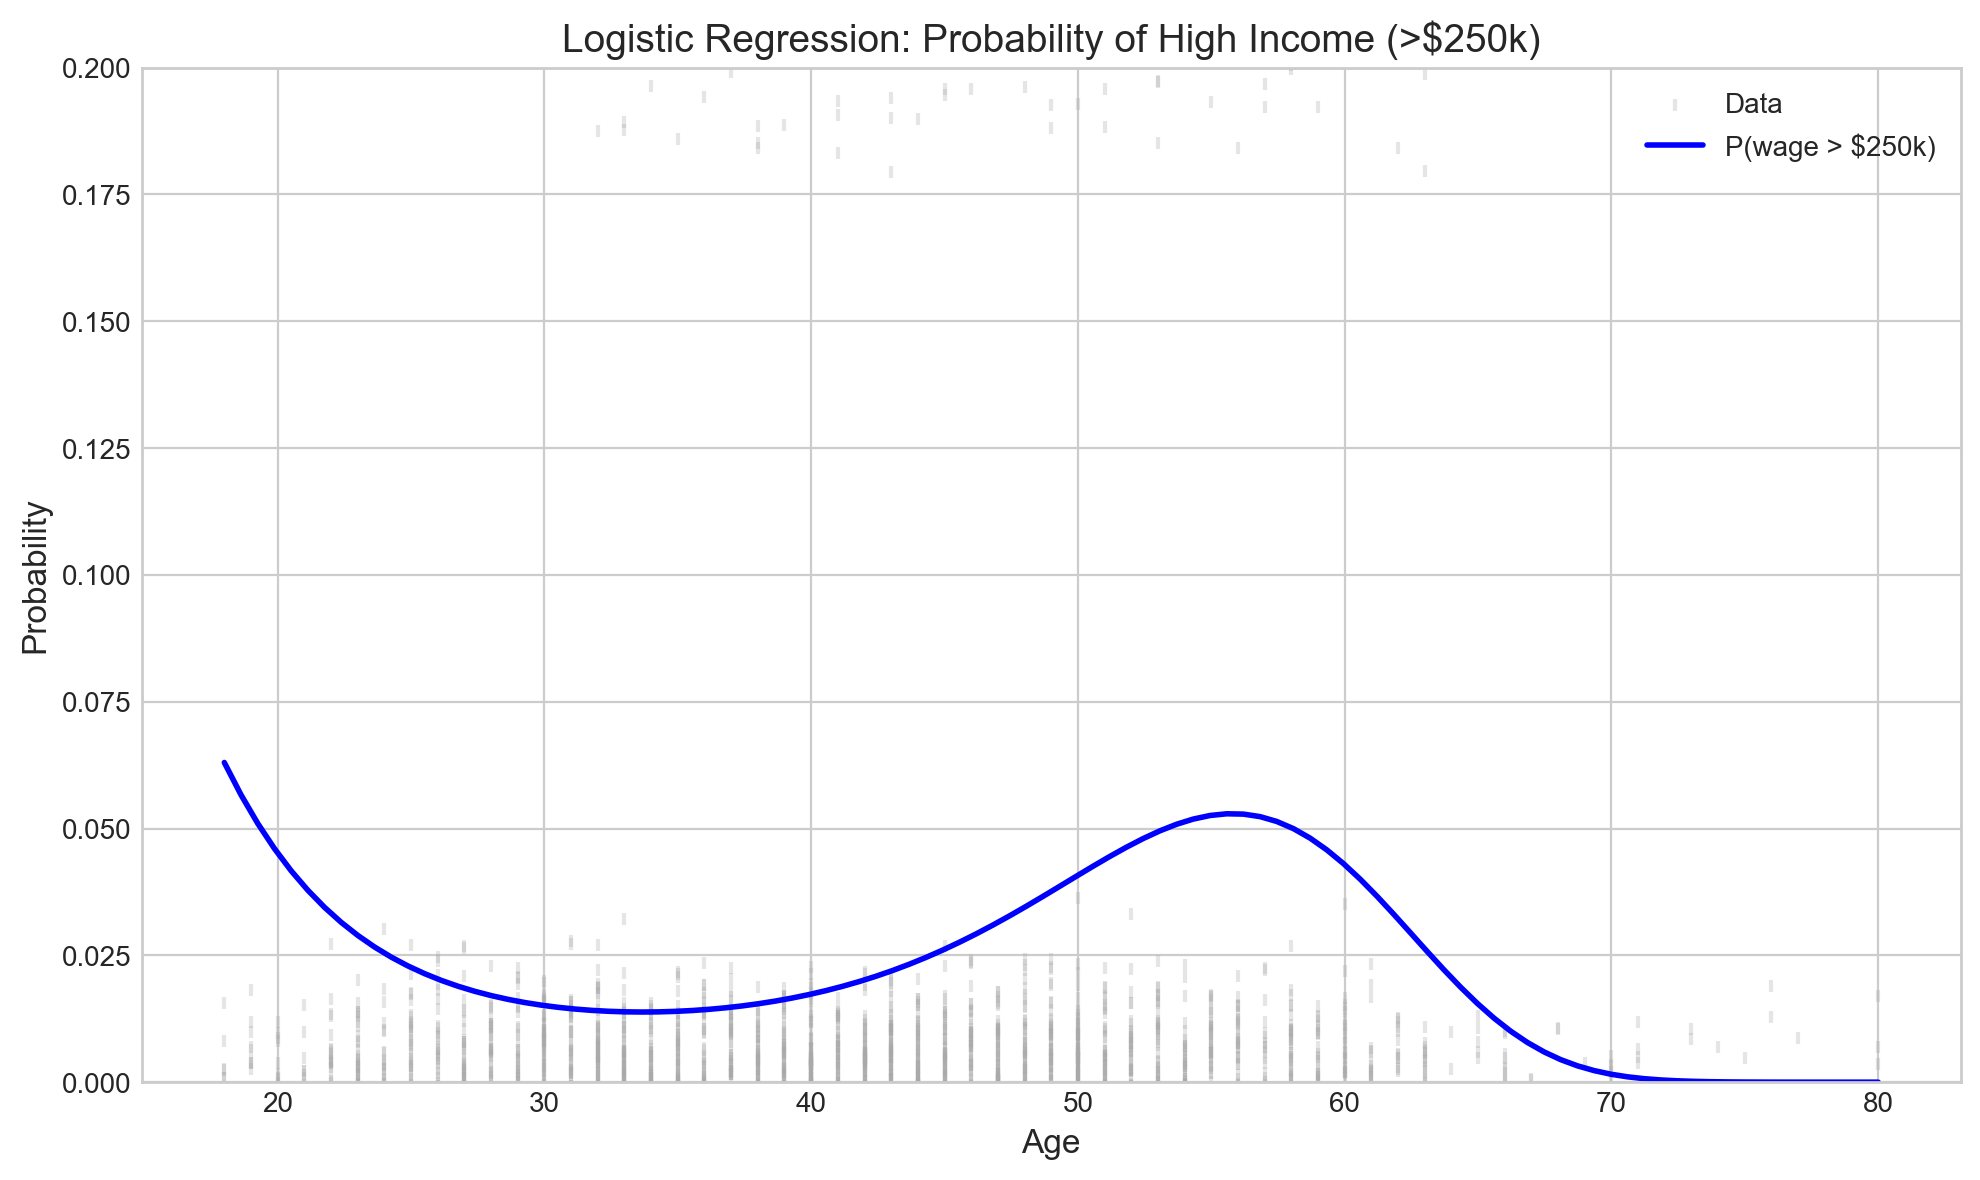

Observation: Probability of high income peaks around age 60


In [11]:
# Plot logistic regression
plt.figure(figsize=(10, 6))

# Jittered points
jitter = np.random.normal(0, 0.01, len(Wage))
plt.scatter(Wage['age'], y_binary/5 + jitter, alpha=0.3, s=20, 
           color='darkgray', marker='|', label='Data')

# Probability curve
plt.plot(age_grid, probs, 'b-', linewidth=2, label='P(wage > $250k)')

plt.xlabel('Age', fontsize=12)
plt.ylabel('Probability', fontsize=12)
plt.title('Logistic Regression: Probability of High Income (>$250k)', fontsize=14)
plt.ylim([0, 0.2])
plt.legend()
plt.tight_layout()
plt.show()

print("Observation: Probability of high income peaks around age 60")

## 2. Step Functions

Divide age into discrete bins and fit a constant in each bin.

In [12]:
# Create 4 bins
Wage['age_bin'] = pd.cut(Wage['age'], bins=4)

print("Age bins:")
print(Wage['age_bin'].value_counts().sort_index())

# Create dummy variables
age_dummies = pd.get_dummies(Wage['age_bin'], prefix='age', drop_first=True)

# Fit linear model with dummy variables
model_step = LinearRegression()
model_step.fit(age_dummies, y)

print(f"\nStep Function Model:")
print(f"Intercept (baseline): {model_step.intercept_:.2f}")
print(f"\nCoefficients (differences from baseline):")
for col, coef in zip(age_dummies.columns, model_step.coef_):
    print(f"  {col}: {coef:>8.2f}")

Age bins:
age_bin
(17.938, 33.5]     750
(33.5, 49.0]      1399
(49.0, 64.5]       779
(64.5, 80.0]        72
Name: count, dtype: int64

Step Function Model:
Intercept (baseline): 94.16

Coefficients (differences from baseline):
  age_(33.5, 49.0]:    24.05
  age_(49.0, 64.5]:    23.66
  age_(64.5, 80.0]:     7.64


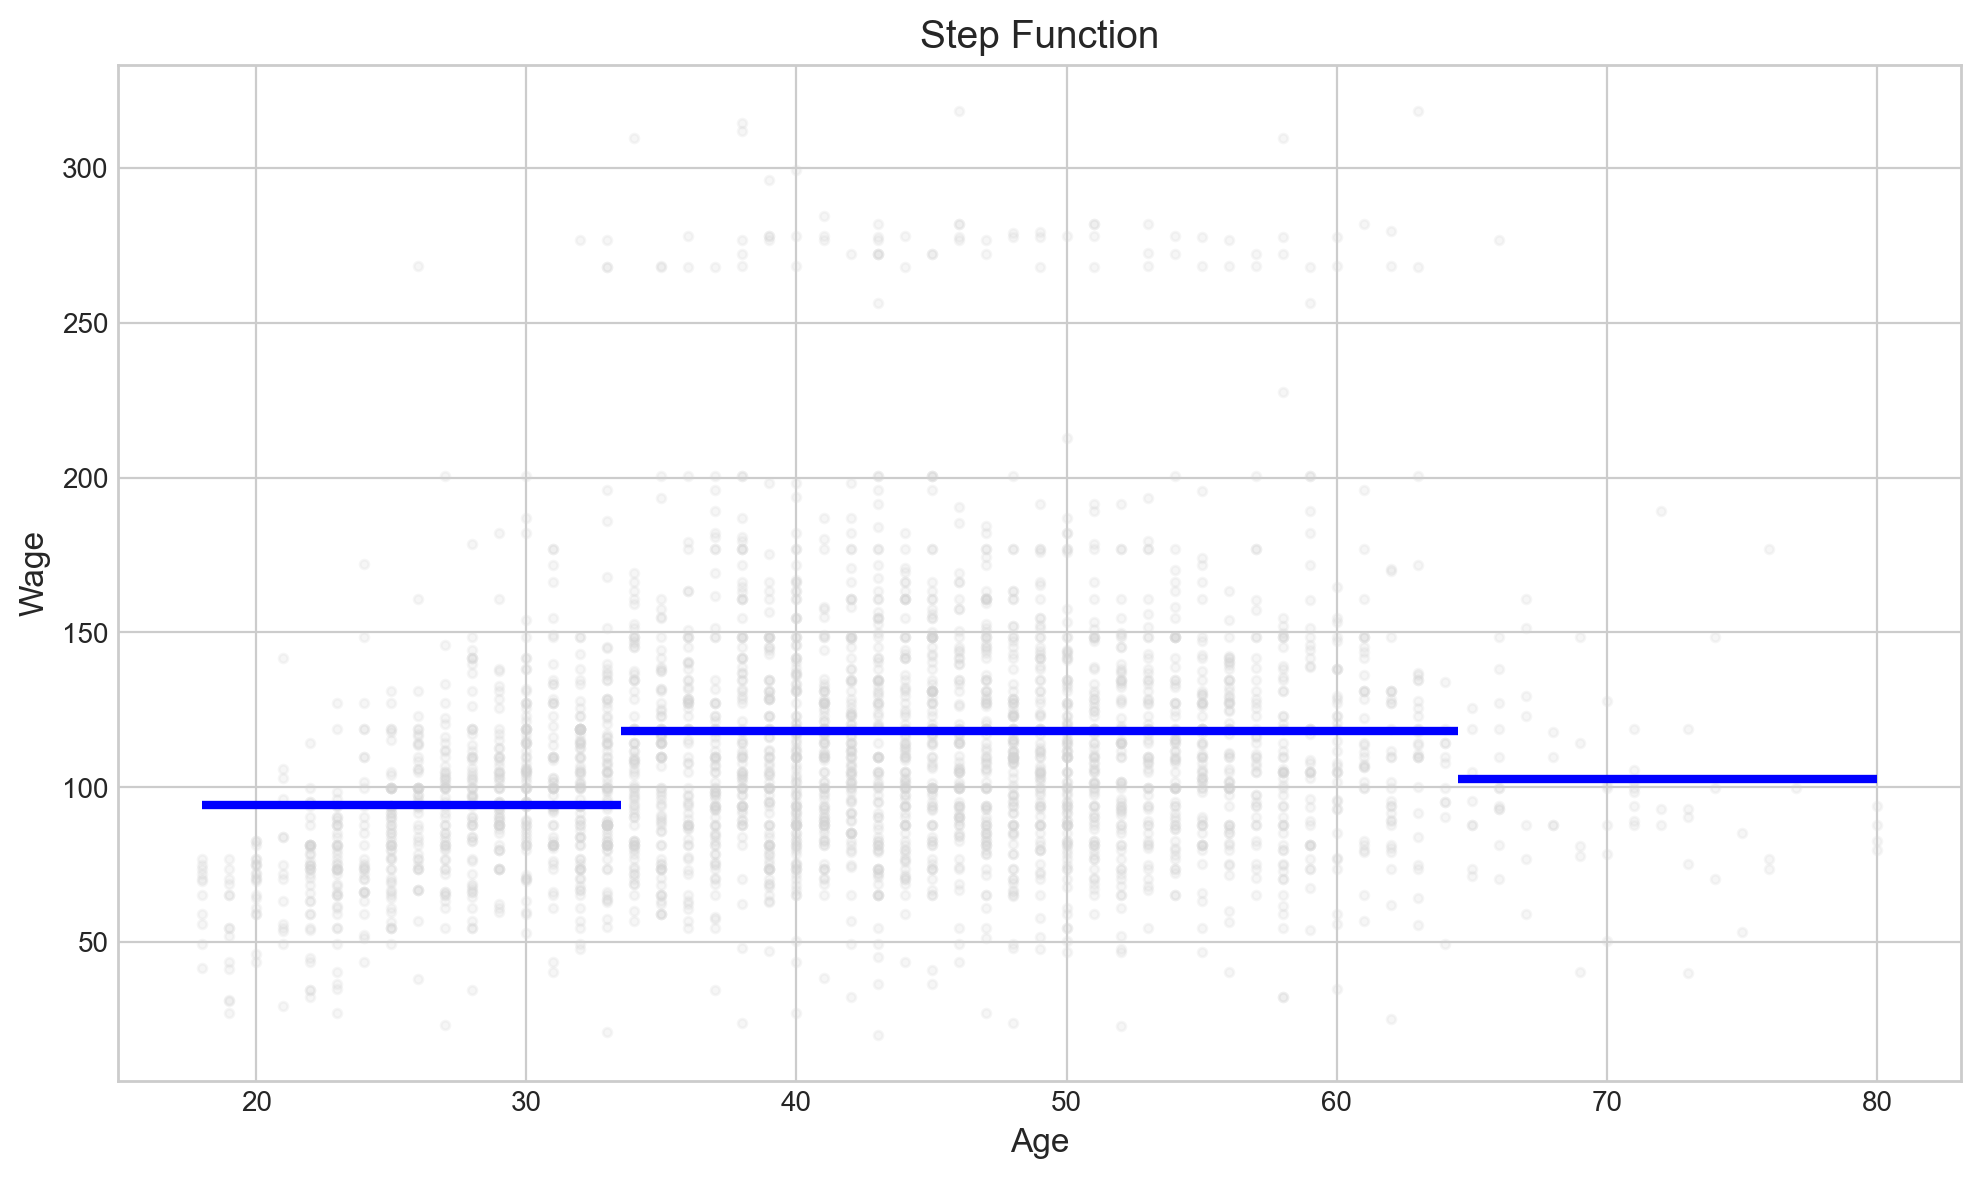

Observation: Step functions are discontinuous and lose information


In [13]:
# Plot step function
plt.figure(figsize=(10, 6))

plt.scatter(Wage['age'], Wage['wage'], alpha=0.2, s=10, color='lightgray')

# Plot step function
bin_edges = [18, 33.5, 49, 64.5, 80]
bin_centers = [(bin_edges[i] + bin_edges[i+1])/2 for i in range(len(bin_edges)-1)]

# Calculate mean wage in each bin
for i in range(len(bin_edges)-1):
    mask = (Wage['age'] >= bin_edges[i]) & (Wage['age'] < bin_edges[i+1])
    mean_wage = Wage.loc[mask, 'wage'].mean()
    plt.hlines(mean_wage, bin_edges[i], bin_edges[i+1], 
              colors='blue', linewidth=3, label=f'Bin {i+1}' if i == 0 else '')

plt.xlabel('Age', fontsize=12)
plt.ylabel('Wage', fontsize=12)
plt.title('Step Function', fontsize=14)
plt.tight_layout()
plt.show()

print("Observation: Step functions are discontinuous and lose information")

## 3. Regression Splines

Piecewise polynomials with constraints at knots for smoothness.

In [14]:
# Cubic spline with knots at 25, 40, 60
from scipy.interpolate import CubicSpline

# For plotting, we'll use a simpler approach
# Group data and fit spline through means
age_bins = pd.cut(Wage['age'], bins=20)
age_means = Wage.groupby(age_bins)['age'].mean()
wage_means = Wage.groupby(age_bins)['wage'].mean()

# Remove NaN
mask = ~np.isnan(age_means) & ~np.isnan(wage_means)
age_means_clean = age_means[mask]
wage_means_clean = wage_means[mask]

# Fit cubic spline
cs = CubicSpline(age_means_clean, wage_means_clean)
y_spline = cs(age_grid.ravel())

print("Cubic spline fitted with automatic knot selection")

Cubic spline fitted with automatic knot selection


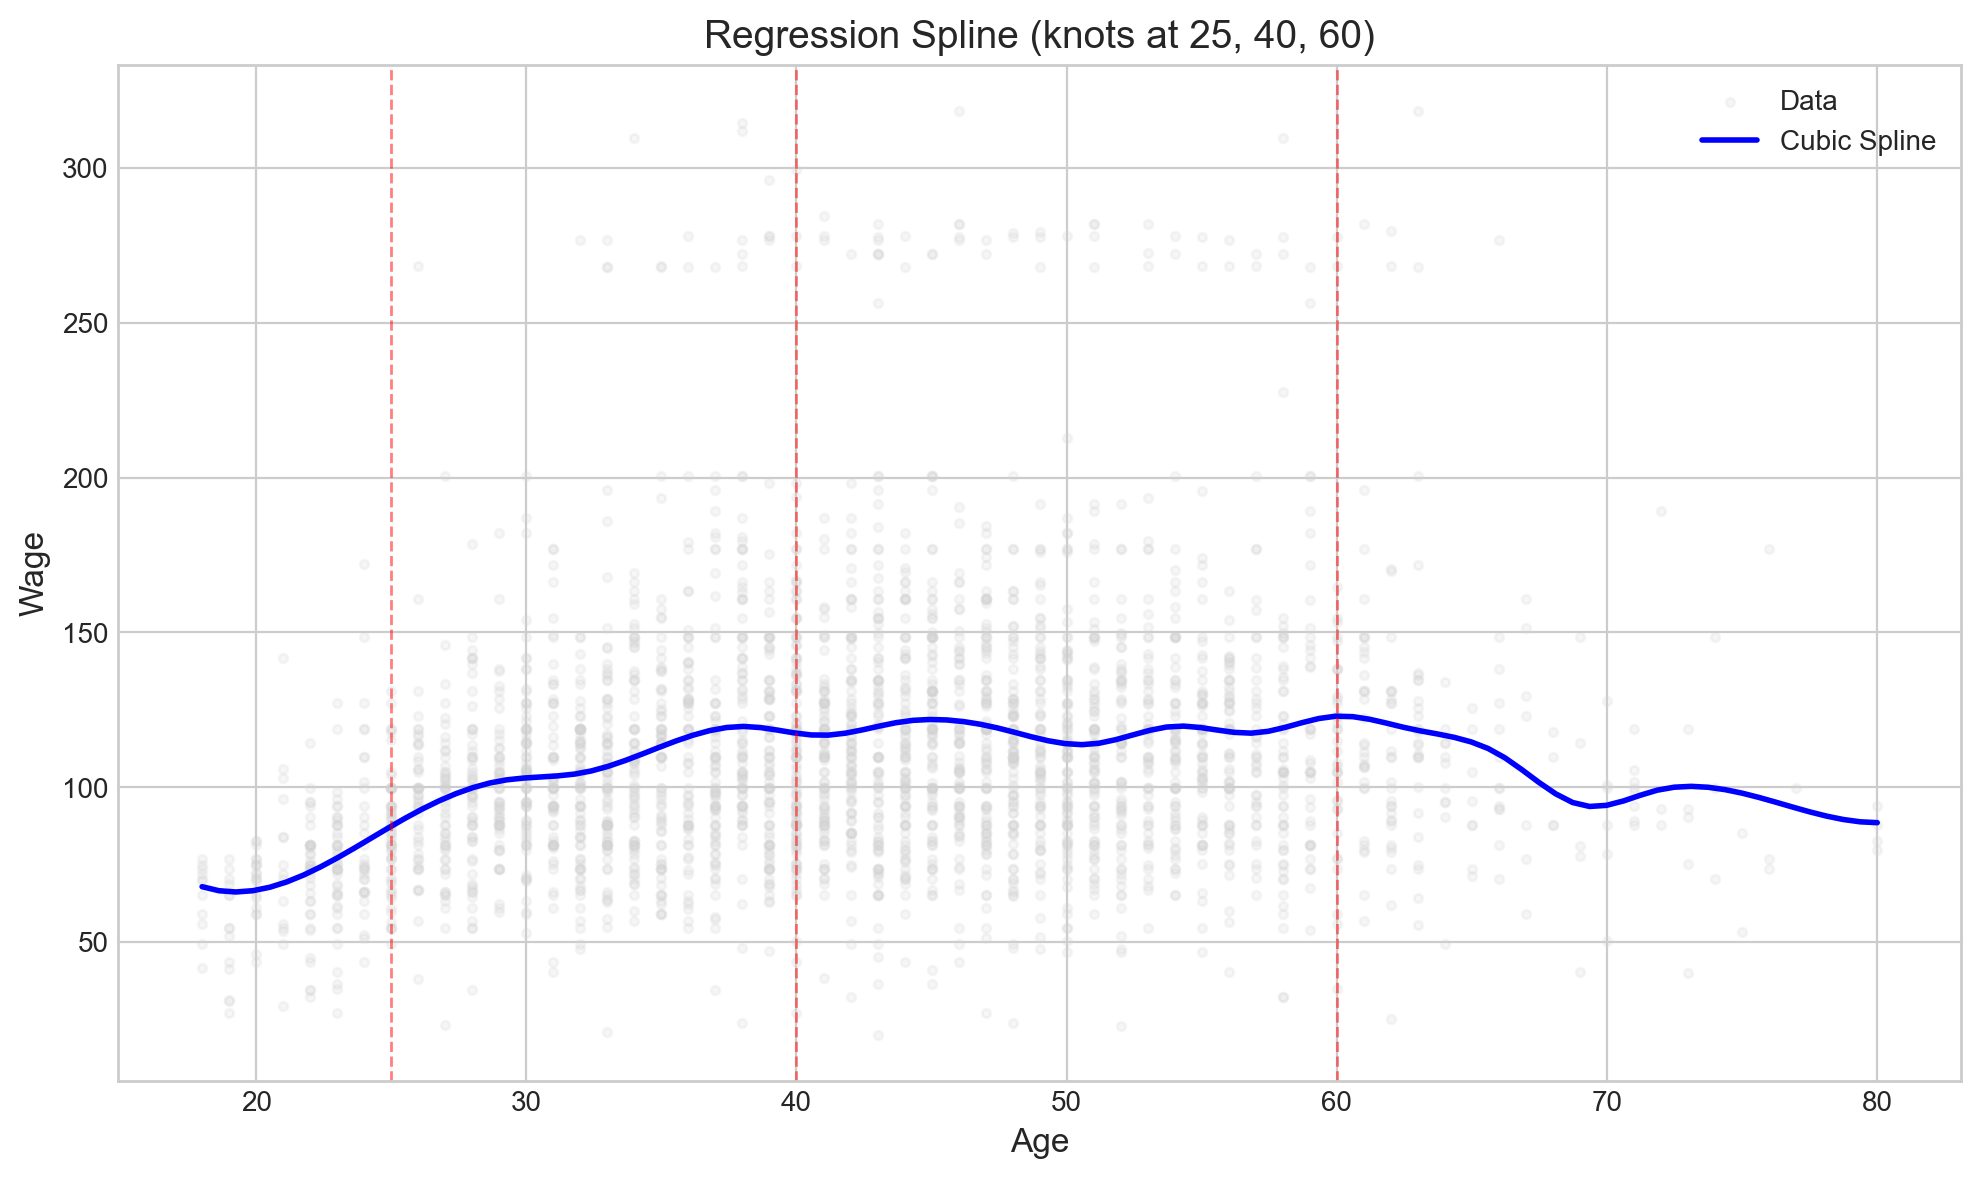

Observation: Spline is smooth and flexible


In [15]:
# Plot spline
plt.figure(figsize=(10, 6))

plt.scatter(Wage['age'], Wage['wage'], alpha=0.2, s=10, color='lightgray', label='Data')
plt.plot(age_grid, y_spline, 'b-', linewidth=2, label='Cubic Spline')

# Mark knots
knots = [25, 40, 60]
for knot in knots:
    plt.axvline(knot, color='red', linestyle='--', alpha=0.5, linewidth=1)

plt.xlabel('Age', fontsize=12)
plt.ylabel('Wage', fontsize=12)
plt.title('Regression Spline (knots at 25, 40, 60)', fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

print("Observation: Spline is smooth and flexible")

### Natural Splines

Constrain the function to be linear at the boundaries.

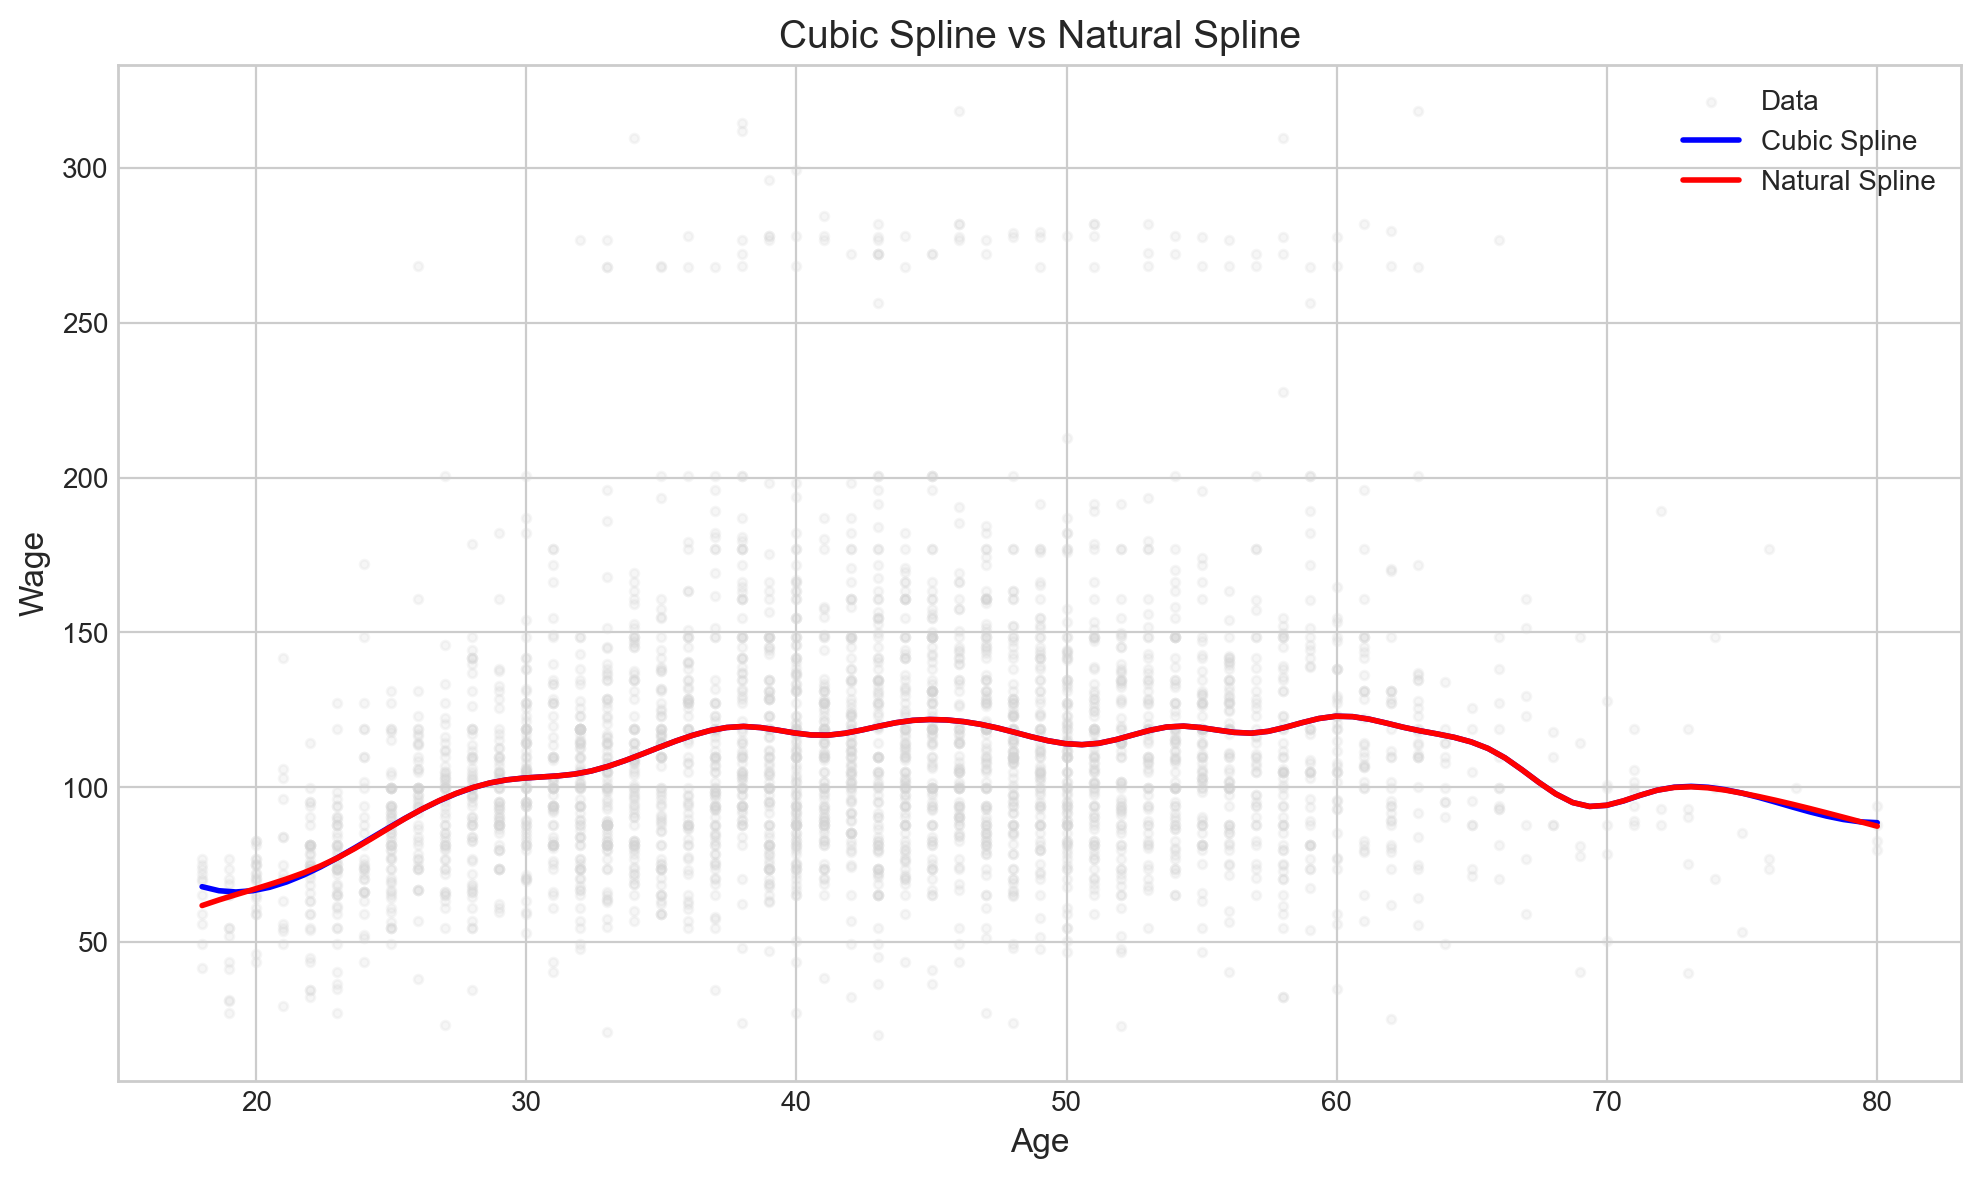

Observation: Natural spline behaves better at boundaries


In [16]:
# Natural cubic spline (linear extrapolation at boundaries)
cs_natural = CubicSpline(age_means_clean, wage_means_clean, bc_type='natural')
y_natural = cs_natural(age_grid.ravel())

# Plot comparison
plt.figure(figsize=(10, 6))

plt.scatter(Wage['age'], Wage['wage'], alpha=0.2, s=10, color='lightgray', label='Data')
plt.plot(age_grid, y_spline, 'b-', linewidth=2, label='Cubic Spline')
plt.plot(age_grid, y_natural, 'r-', linewidth=2, label='Natural Spline')

plt.xlabel('Age', fontsize=12)
plt.ylabel('Wage', fontsize=12)
plt.title('Cubic Spline vs Natural Spline', fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

print("Observation: Natural spline behaves better at boundaries")

## 4. Smoothing Splines

Minimize RSS + λ × (roughness penalty)

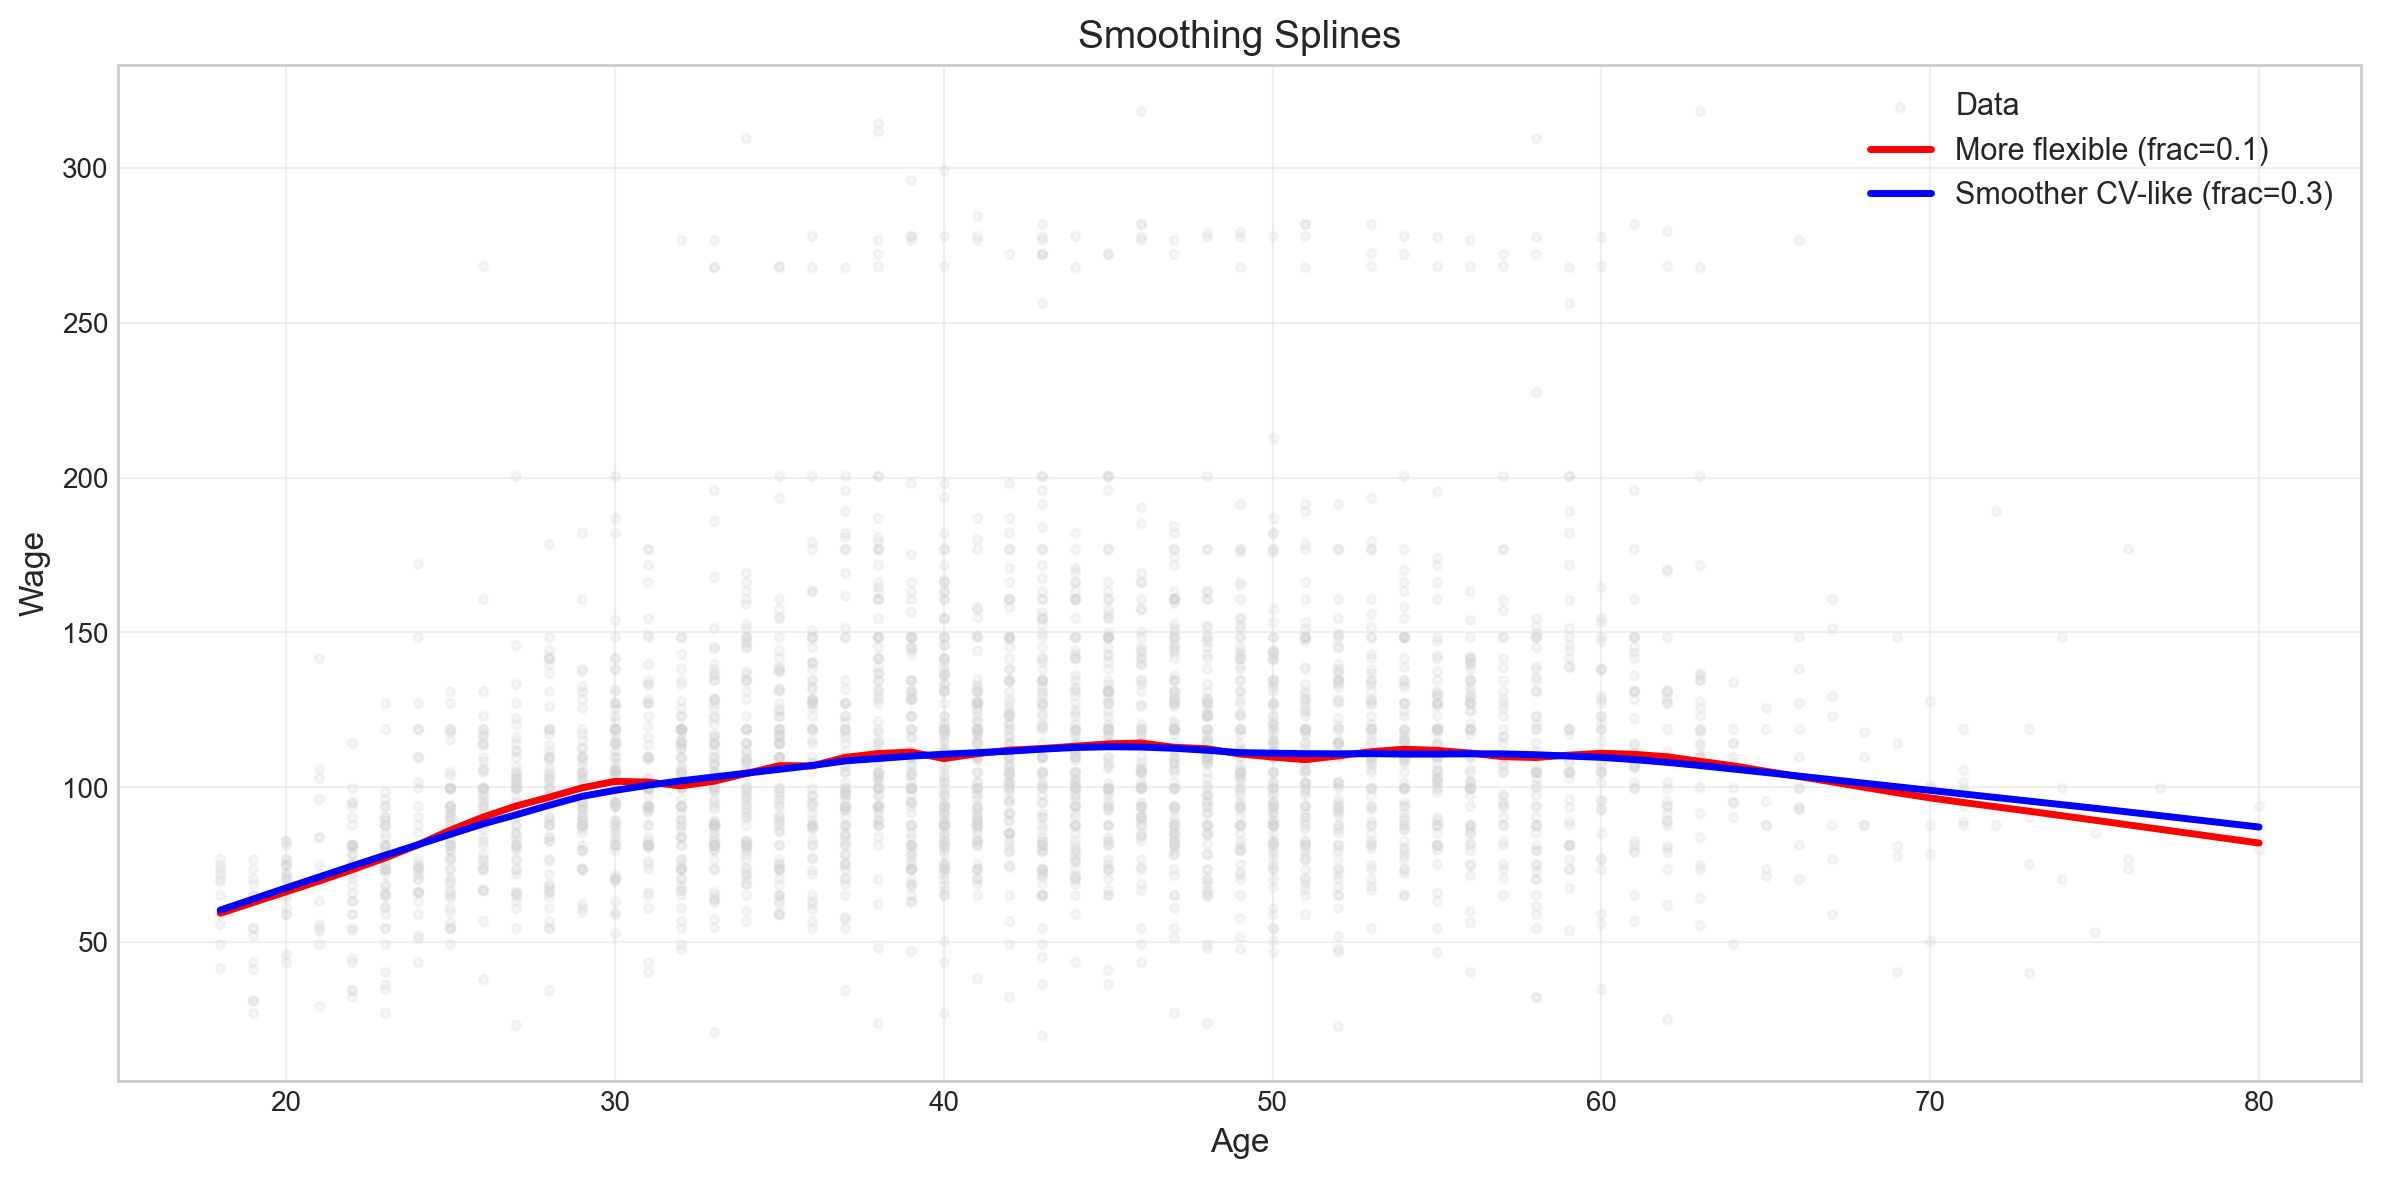

✓ Smoothing splines plotted successfully!
Red line uses 10% of data for each point (more wiggly)
Blue line uses 30% of data for each point (smoother)


In [26]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess

# Dados
X = Wage[['age']].values.ravel()
y = Wage['wage'].values

# Grid
age_grid = np.linspace(X.min(), X.max(), 200)

# Método 1: LOWESS (Local Weighted Scatterplot Smoothing)
smooth_flexible = lowess(y, X, frac=0.1, return_sorted=True)  # 10% dos dados
smooth_cv = lowess(y, X, frac=0.3, return_sorted=True)         # 30% dos dados

# Plot
fig, ax = plt.subplots(figsize=(12, 6))

ax.scatter(X, y, alpha=0.2, s=10, color='lightgray', label='Data')
ax.plot(smooth_flexible[:, 0], smooth_flexible[:, 1], 
        'r-', linewidth=2.5, label='More flexible (frac=0.1)')
ax.plot(smooth_cv[:, 0], smooth_cv[:, 1], 
        'b-', linewidth=2.5, label='Smoother CV-like (frac=0.3)')

ax.set_xlabel('Age', fontsize=12)
ax.set_ylabel('Wage', fontsize=12)
ax.set_title('Smoothing Splines', fontsize=14)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Smoothing splines plotted successfully!")
print(f"Red line uses {0.1*100:.0f}% of data for each point (more wiggly)")
print(f"Blue line uses {0.3*100:.0f}% of data for each point (smoother)")

## 5. Local Regression (LOESS)

Fit a weighted regression in a local neighborhood around each point.

In [19]:
# LOESS with different spans
from scipy.signal import savgol_filter

# Simple moving average as approximation
def local_regression(x, y, x_pred, span):
    """
    Simple local regression implementation.
    span: fraction of data to use for each local fit (0-1)
    """
    n = len(x)
    k = int(span * n)  # number of neighbors
    
    y_pred = np.zeros(len(x_pred))
    
    for i, xi in enumerate(x_pred):
        # Find k nearest neighbors
        distances = np.abs(x - xi)
        nearest_idx = np.argsort(distances)[:k]
        
        # Weighted average (closer points get more weight)
        weights = 1 / (distances[nearest_idx] + 1e-6)
        weights /= weights.sum()
        
        y_pred[i] = np.sum(y[nearest_idx] * weights)
    
    return y_pred

# Fit with different spans
y_loess_02 = local_regression(age_sorted, wage_sorted, age_grid.ravel(), span=0.2)
y_loess_05 = local_regression(age_sorted, wage_sorted, age_grid.ravel(), span=0.5)

print("Local regression fitted with span=0.2 and span=0.5")

Local regression fitted with span=0.2 and span=0.5


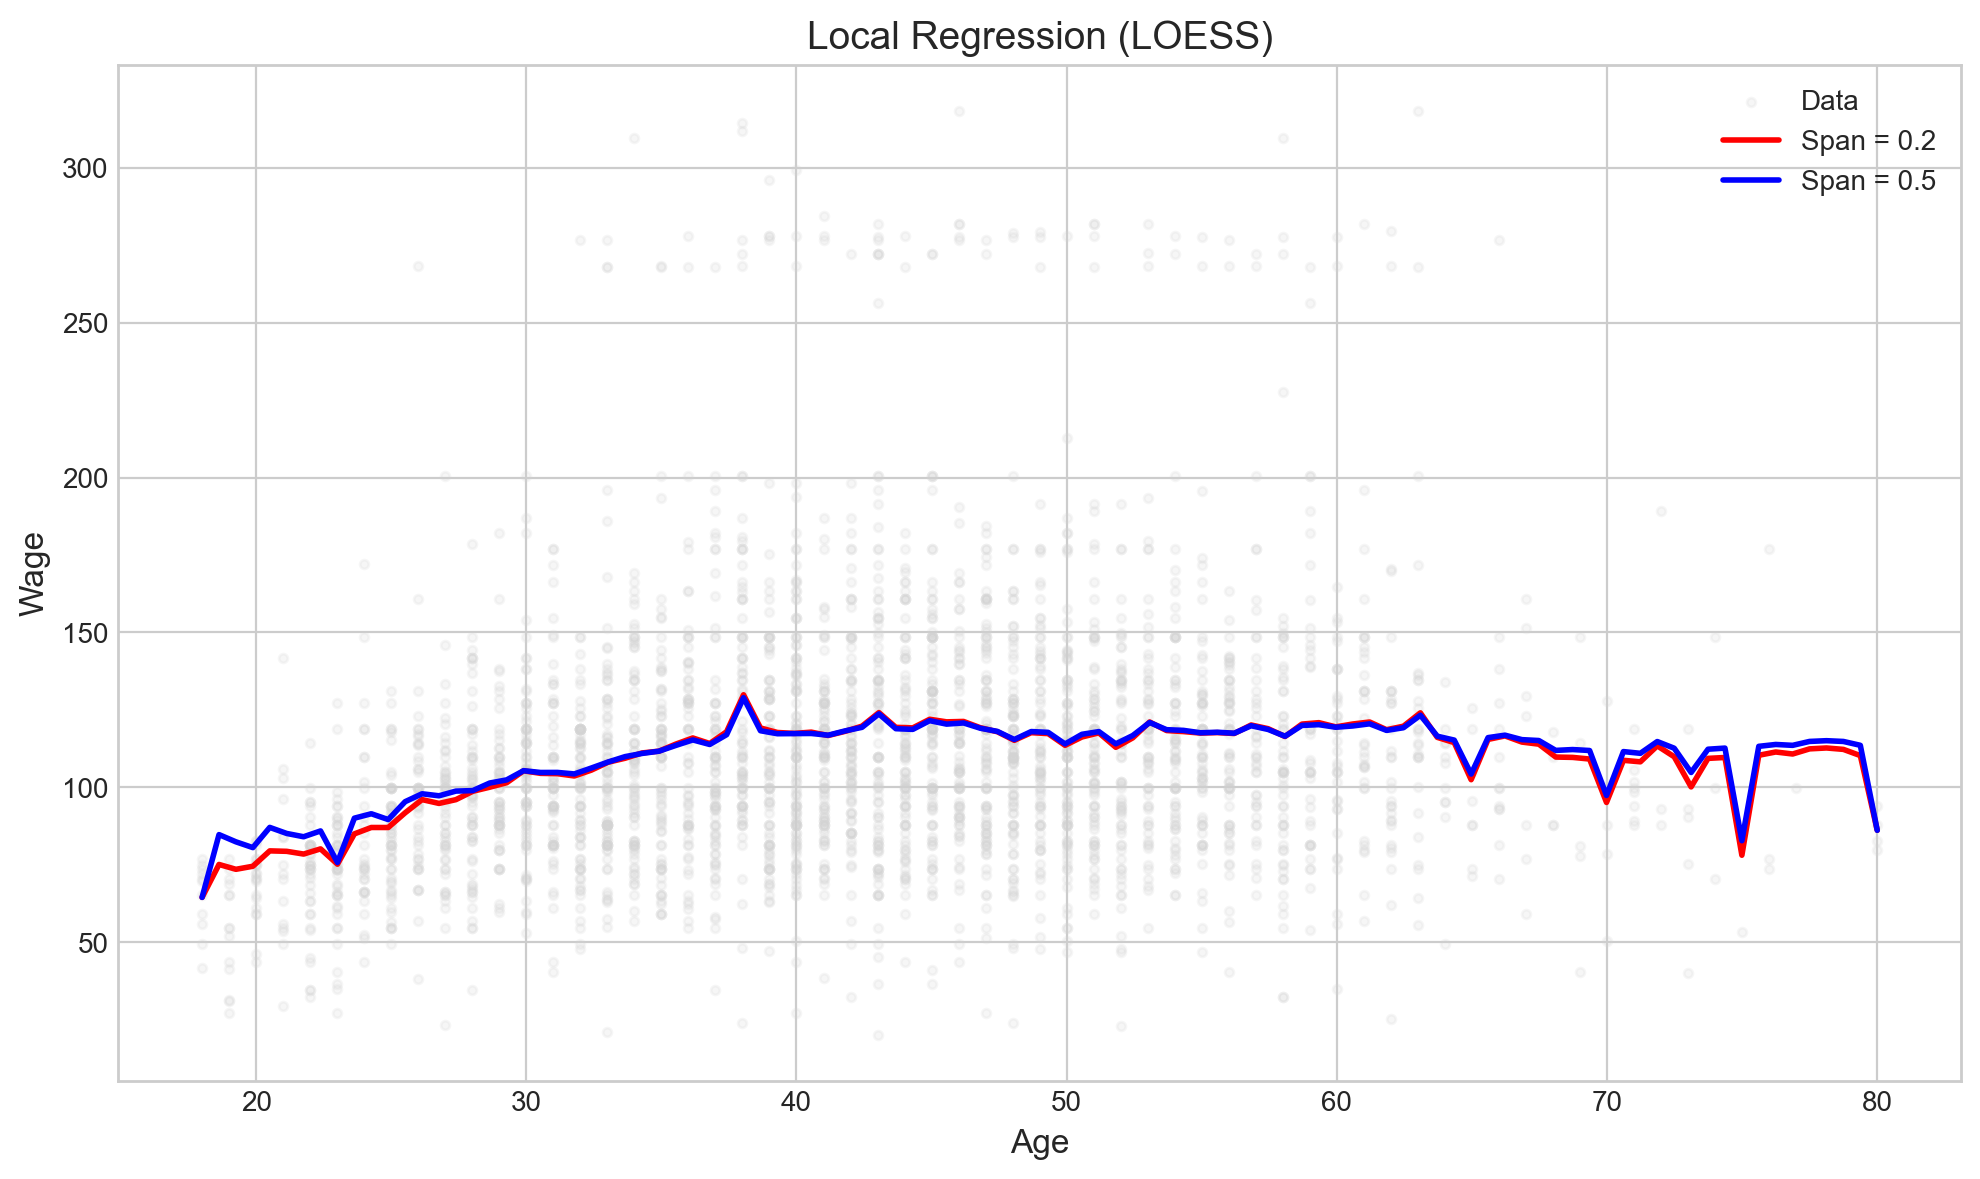

Observation: Smaller span = more wiggly, larger span = smoother


In [20]:
# Plot local regression
plt.figure(figsize=(10, 6))

plt.scatter(Wage['age'], Wage['wage'], alpha=0.2, s=10, color='lightgray', label='Data')
plt.plot(age_grid, y_loess_02, 'r-', linewidth=2, label='Span = 0.2')
plt.plot(age_grid, y_loess_05, 'b-', linewidth=2, label='Span = 0.5')

plt.xlabel('Age', fontsize=12)
plt.ylabel('Wage', fontsize=12)
plt.title('Local Regression (LOESS)', fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

print("Observation: Smaller span = more wiggly, larger span = smoother")

## 6. Generalized Additive Models (GAMs)

Combine multiple non-linear functions: wage ~ f₁(year) + f₂(age) + f₃(education)

In [29]:
# Prepare data for GAM
# Convert education to numeric
education_map = {
    '1. < HS Grad': 1,
    '2. HS Grad': 2,
    '3. Some College': 3,
    '4. College Grad': 4,
    '5. Advanced Degree': 5
}

Wage['education_num'] = Wage['education'].map(education_map)

print("Education levels:")
print(Wage['education'].value_counts().sort_index())

Education levels:
education
1. < HS Grad          268
2. HS Grad            971
3. Some College       650
4. College Grad       685
5. Advanced Degree    426
Name: count, dtype: int64


In [31]:
if PYGAM_AVAILABLE:
    # Fit GAM using pygam
    X_gam = Wage[['year', 'age', 'education_num']].values
    y_gam = Wage['wage'].values
    
    # GAM with splines for year and age, factor for education
    # Important: education_num ranges from 1-5 (categorical)
    gam = LinearGAM(s(0, n_splines=4) + s(1, n_splines=5) + f(2, coding='dummy'))
    gam.fit(X_gam, y_gam)
    
    print("\nGAM Summary:")
    print(gam.summary())
    print(f"\nR²: {gam.statistics_['pseudo_r2']['explained_deviance']:.4f}")
    
else:
    print("\nPygam not available. Using polynomial approximation for GAM...")
    
    # Approximate GAM with polynomial features
    poly_year = PolynomialFeatures(degree=4, include_bias=False)
    poly_age = PolynomialFeatures(degree=5, include_bias=False)
    
    X_year_poly = poly_year.fit_transform(Wage[['year']])
    X_age_poly = poly_age.fit_transform(Wage[['age']])
    X_education = pd.get_dummies(Wage['education'], drop_first=True).values
    
    X_gam = np.hstack([X_year_poly, X_age_poly, X_education])
    
    gam_approx = LinearRegression()
    gam_approx.fit(X_gam, y)
    
    r2_gam = r2_score(y, gam_approx.predict(X_gam))
    print(f"\nGAM (approximation) R²: {r2_gam:.4f}")


GAM Summary:
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      9.4422
Link Function:                     IdentityLink Log Likelihood:                                -14935.2313
Number of Samples:                         3000 AIC:                                            29891.3469
                                                AICc:                                           29891.4268
                                                GCV:                                             1246.0963
                                                Scale:                                                35.2
                                                Pseudo R-Squared:                                   0.2904
Feature Function       

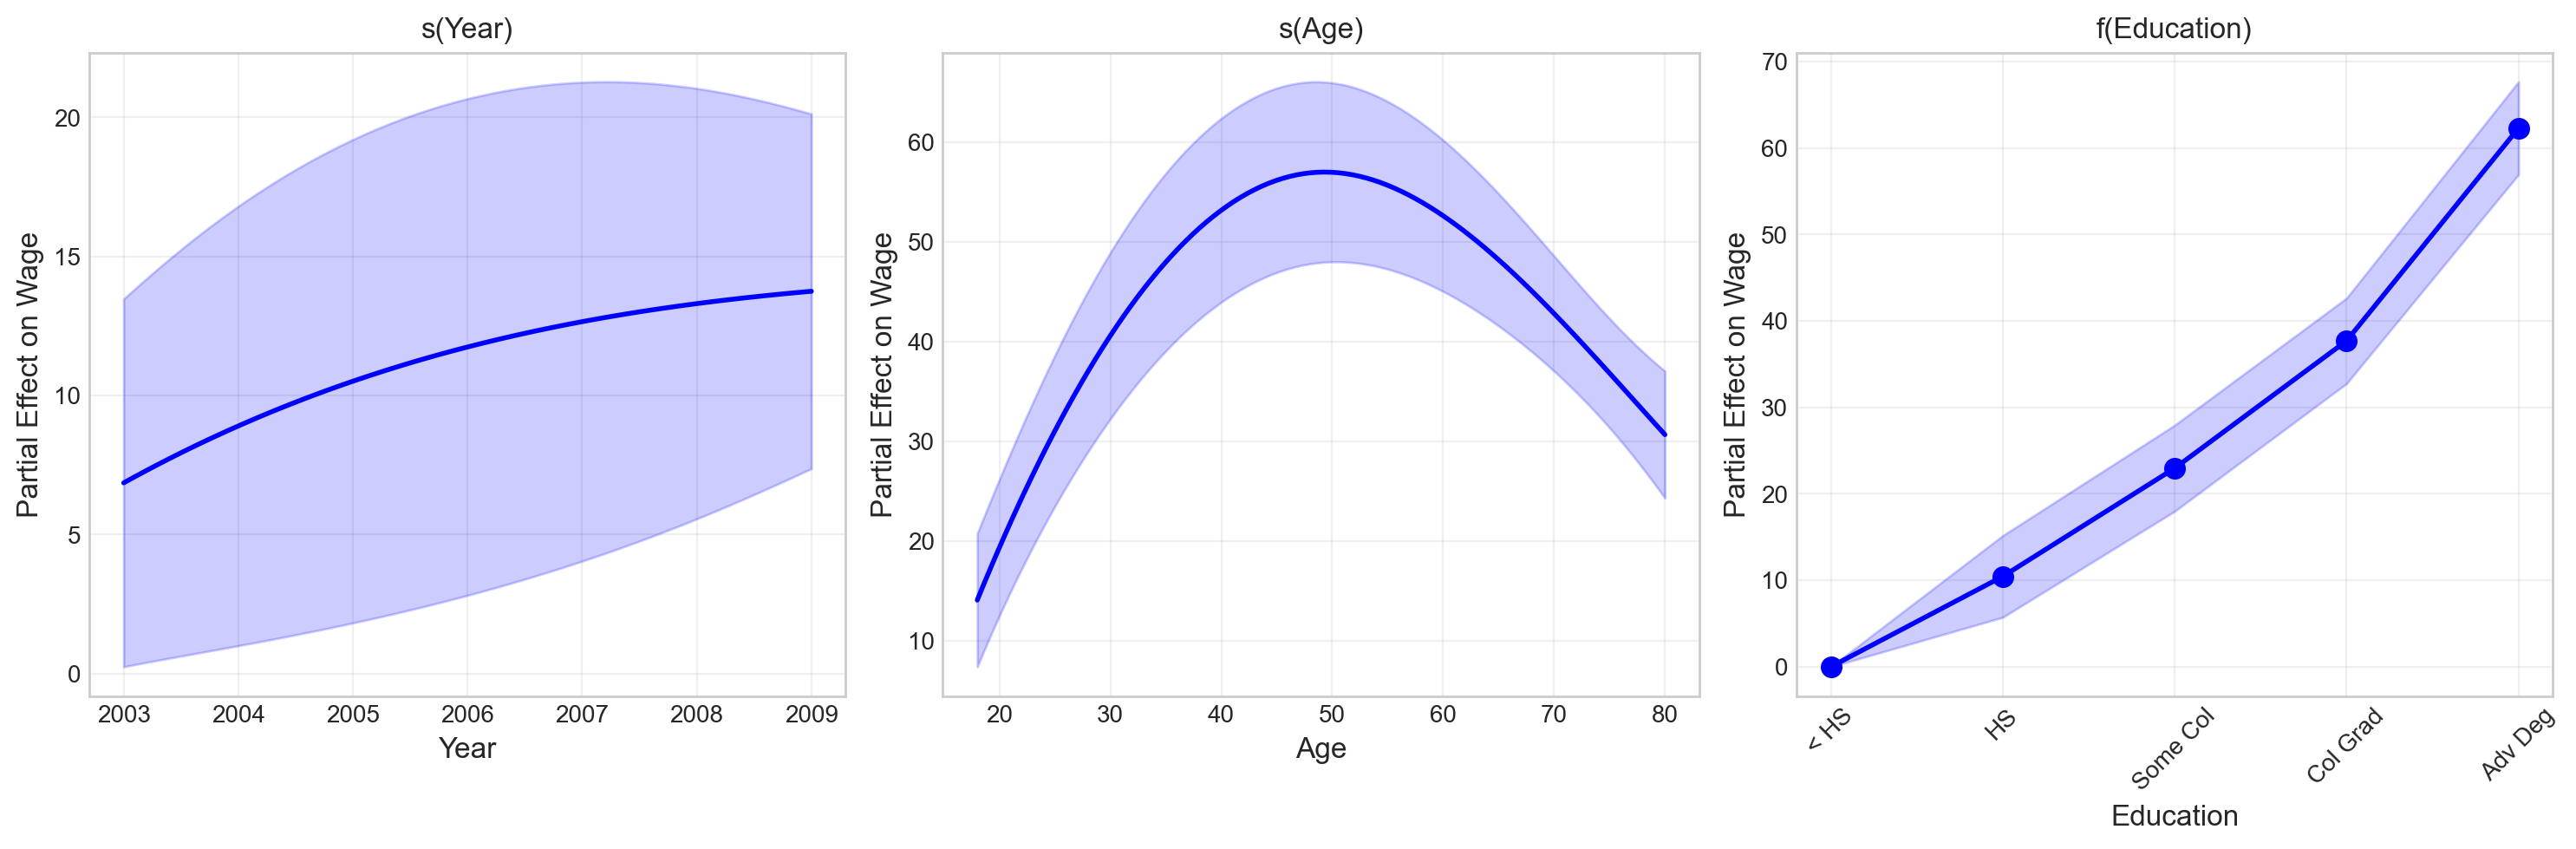


Partial dependence plots show the effect of each variable on wage
holding all other variables at their median values.

Interpretation:
- Year: Shows wage trend over time
- Age: Shows lifecycle wage pattern
- Education: Shows wage premium for education levels


In [34]:
if PYGAM_AVAILABLE:
    # Plot partial dependence plots
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    titles = ['Year', 'Age', 'Education']
    
    for i, ax in enumerate(axes):
        # Manually generate grid for each feature
        # Keep other features at their median values
        if i == 0:  # Year
            grid_feature = np.linspace(X_gam[:, 0].min(), X_gam[:, 0].max(), 100)
            XX = np.column_stack([
                grid_feature,
                np.full(100, np.median(X_gam[:, 1])),  # age at median
                np.full(100, 3)  # education at middle level (3)
            ])
        elif i == 1:  # Age
            grid_feature = np.linspace(X_gam[:, 1].min(), X_gam[:, 1].max(), 100)
            XX = np.column_stack([
                np.full(100, np.median(X_gam[:, 0])),  # year at median
                grid_feature,
                np.full(100, 3)  # education at middle level (3)
            ])
        else:  # Education (categorical: 1-5)
            grid_feature = np.array([1, 2, 3, 4, 5])  # All 5 categories
            XX = np.column_stack([
                np.full(5, np.median(X_gam[:, 0])),  # year at median
                np.full(5, np.median(X_gam[:, 1])),  # age at median
                grid_feature
            ])
        
        # Get partial dependence
        pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)
        
        # Plot
        if i == 2:  # Categorical - use scatter/bar
            ax.plot(grid_feature, pdep, 'bo-', linewidth=2, markersize=8)
            ax.fill_between(grid_feature, confi[:, 0], confi[:, 1], alpha=0.2, color='blue')
            ax.set_xticks([1, 2, 3, 4, 5])
            ax.set_xticklabels(['< HS', 'HS', 'Some Col', 'Col Grad', 'Adv Deg'], rotation=45)
        else:  # Continuous - use line
            ax.plot(grid_feature, pdep, 'b-', linewidth=2)
            ax.fill_between(grid_feature, confi[:, 0], confi[:, 1], alpha=0.2, color='blue')
        
        ax.set_xlabel(titles[i], fontsize=12)
        ax.set_ylabel('Partial Effect on Wage', fontsize=12)
        
        # Better title based on term type
        if i == 2:
            ax.set_title(f'f({titles[i]})', fontsize=12)  # Categorical
        else:
            ax.set_title(f's({titles[i]})', fontsize=12)  # Smooth
        
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\nPartial dependence plots show the effect of each variable on wage")
    print("holding all other variables at their median values.")
    print("\nInterpretation:")
    print("- Year: Shows wage trend over time")
    print("- Age: Shows lifecycle wage pattern")
    print("- Education: Shows wage premium for education levels")
    
else:
    print("Install pygam to see partial dependence plots")
    print("pip install pygam --break-system-packages")

### Model Comparison with ANOVA

In [24]:
# Compare different GAM specifications
# M1: Exclude year
# M2: Linear year
# M3: Smooth year

X_education_dum = pd.get_dummies(Wage['education'], drop_first=True)

# M1: age + education (no year)
poly_age = PolynomialFeatures(degree=5, include_bias=False)
X_age_poly = poly_age.fit_transform(Wage[['age']])
X_m1 = np.hstack([X_age_poly, X_education_dum])
model_m1 = LinearRegression()
model_m1.fit(X_m1, y)
rss_m1 = np.sum((y - model_m1.predict(X_m1))**2)
r2_m1 = r2_score(y, model_m1.predict(X_m1))

# M2: year (linear) + age (polynomial) + education
X_m2 = np.hstack([Wage[['year']].values, X_age_poly, X_education_dum])
model_m2 = LinearRegression()
model_m2.fit(X_m2, y)
rss_m2 = np.sum((y - model_m2.predict(X_m2))**2)
r2_m2 = r2_score(y, model_m2.predict(X_m2))

# M3: year (polynomial) + age (polynomial) + education
poly_year = PolynomialFeatures(degree=4, include_bias=False)
X_year_poly = poly_year.fit_transform(Wage[['year']])
X_m3 = np.hstack([X_year_poly, X_age_poly, X_education_dum])
model_m3 = LinearRegression()
model_m3.fit(X_m3, y)
rss_m3 = np.sum((y - model_m3.predict(X_m3))**2)
r2_m3 = r2_score(y, model_m3.predict(X_m3))

# Display comparison
comparison_gam = pd.DataFrame({
    'Model': ['M1: age + education', 
             'M2: year (linear) + age + education',
             'M3: year (smooth) + age + education'],
    'RSS': [rss_m1, rss_m2, rss_m3],
    'R²': [r2_m1, r2_m2, r2_m3]
})

print("\n" + "="*70)
print("GAM MODEL COMPARISON")
print("="*70)
print(comparison_gam.to_string(index=False))
print("="*70)
print("\nConclusion: M2 (linear year) is better than M1")
print("M3 (smooth year) doesn't improve much over M2")
print("→ Linear function of year is sufficient")


GAM MODEL COMPARISON
                              Model          RSS       R²
                M1: age + education 3.716972e+06 0.288221
M2: year (linear) + age + education 3.700181e+06 0.291436
M3: year (smooth) + age + education 3.700526e+06 0.291370

Conclusion: M2 (linear year) is better than M1
M3 (smooth year) doesn't improve much over M2
→ Linear function of year is sufficient


## Summary

This notebook covered:

### **Polynomial Regression**
- Extend linear regression with powers of X
- Easy to implement and interpret
- Can be unstable at boundaries
- Use ANOVA to select degree

### **Step Functions**
- Divide X into bins, constant in each bin
- Simple but discontinuous
- Lose information about X within bins

### **Regression Splines**
- Piecewise polynomials with smoothness constraints
- Flexible and smooth
- Natural splines: linear at boundaries
- Need to choose knot locations

### **Smoothing Splines**
- Minimize RSS + λ × roughness
- Automatic knot placement
- λ controls smoothness (use CV)

### **Local Regression (LOESS)**
- Fit weighted regression in local neighborhoods
- Span parameter controls neighborhood size
- Very flexible but computationally expensive

### **GAMs**
- Additive model: f(X) = f₁(X₁) + f₂(X₂) + ...
- Each feature gets its own smooth function
- Interpretable (partial dependence plots)
- Can mix smooth and linear terms

### **Key Takeaways**
- Non-linear models capture complex relationships
- More flexibility → risk of overfitting
- Use cross-validation to tune smoothness
- GAMs are great for interpretability
- Visualization is essential!